# Studying Sensitivies

In [1]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,normalize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
import IPython
import ast
import json
from scipy.stats import norm
import joblib
%load_ext autoreload
%autoreload 2
%aimport IS_misc_functions
from IS_misc_functions import *
from misc_functions import *
from actuarial_training import *
from MtM_training import *
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

import json
#import warnings
#warnings.filterwarnings("ignore")

Load the models

In [2]:
model_999 = keras.models.load_model("model_mtm_0999.h5",compile = False)
model_999.compile()
scaler_mtm = joblib.load('scaler_mtm.gz')

C:\Users\julia\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Consider a baseline Portfolio

In [3]:
N_Iter = 1000 # Number of Iterations

B = 1 # Batch Size

# Number of States considered
S =17
n_obligors = 100

# Bounds for the parameters
ELGD_bounds = 0,0.6
EAD_bounds = 0,1
rho_bounds = 0.15,0.7
c_bounds = 0,0.1
g_bounds = 2,S
D_bounds = 2,10
obligor_bounds = 99,100

# # # # #Homogeneous Parameters
# # # Bounds for the parameters
# ELGD_bounds = 0.3,0.3
# EAD_bounds = 0.5,0.5
# rho_bounds = 0.35,0.35
# c_bounds = 0.05,0.05
# g_bounds = 4,5
# D_bounds = 5,5
# obligor_bounds = 99,100

In [5]:
B = 1 # Batch Size

max_obligors = obligor_bounds[1]


In [4]:
transition_matrix = pd.read_csv("transition_matrix_SP.csv",delimiter = ",")
PDs = np.maximum(np.array(transition_matrix["D"])/100,1e-8)
SP_dict = trans_matrix_to_dict(transition_matrix)
with open("probs.txt") as tweetfile:
    probs = json.load(tweetfile)
probs = {float(k):float(v) for k,v in probs.items()}
PDs =  np.maximum(np.array([float(k) for k,v in probs.items()])/100,1e-10)
PD_distribution = np.array([float(v) for k,v in probs.items()])
S = 17
g_bounds = 2,S
g_vals = np.arange(g_bounds[0],g_bounds[1])
g_probs = np.flip(np.concatenate([[0.0001,0.0001],PD_distribution]))
g_probs = g_probs/np.sum(g_probs)
PDs_reverted = np.flip(np.concatenate([[1e-10,1e-10],PDs]))

In [6]:
# Fix the randomness
np.random.seed(seed=636)

ELGD,EAD,rho,c,g,D = create_sample_MtM(ELGD_bounds,EAD_bounds,rho_bounds,c_bounds,g_bounds,D_bounds,obligor_bounds,B,
                                                   g_vals,g_probs)

LGD_Vector1 = np.zeros((1,100))
LGD_Vector2 = np.zeros((1,100))
LGD_Vector1[ELGD>0] = 0.1
LGD_Vector2[ELGD>0] = 0.45

D[D>0]=1
rho[rho>0] = 0.5

Change Number of Obligors

In [43]:
# # Fix the randomness
# for j in range(384,1000):
#     print(j)
#     np.random.seed(seed=j)

#     ELGD,EAD,rho,c,g,D = create_sample_MtM(ELGD_bounds,EAD_bounds,rho_bounds,c_bounds,g_bounds,D_bounds,obligor_bounds,B,
#                                                        g_vals,g_probs)

#     LGD_Vector1 = np.zeros((1,100))
#     LGD_Vector2 = np.zeros((1,100))
#     LGD_Vector1[ELGD>0] = 0.1
#     LGD_Vector2[ELGD>0] = 0.45

#     D[D>0]=1
#     rho[rho>0] = 0.5

#     reduced_obligors = 50
#     N = np.zeros((1,max_obligors))
#     N[0,:] = np.pad(np.repeat(1,reduced_obligors),(0,max_obligors-reduced_obligors)) # Number of Obligors 
#     ELGD,EAD,rho,c,g,D = ELGD*N,EAD*N/np.sum(EAD*N),rho*N,c*N,g*N,D*N
#     LGD_Vector1 = np.zeros((1,100))
#     LGD_Vector2 = np.zeros((1,100))
#     LGD_Vector1[ELGD>0] = 0.1
#     LGD_Vector2[ELGD>0] = 0.45

#     EAD_01_change = []
#     EAD_01_change_approx = []
#     # Compute base GA
#     GA_approx_01 = GA_GM(PD = 0, ELGD =LGD_Vector2[0,:][EAD[0,:]>0],
#                                        A = EAD[0,:][EAD[0,:]>0], 
#                              M= D[0,:][EAD[0,:]>0],
#                           q=0.999,        
#                          r = r_nelson,
#                          T=1,
#                          g= np.array(g[0,:][EAD[0,:]>0],dtype = int),
#                          trans_prob=SP_dict["trans_prob"],#N times S matrix
#                          psi = 0.4, # Market Sharpe Ratio,
#                          rho = rho[0,:][EAD[0,:]>0],
#                          c = c[0,:][EAD[0,:]>0],
#                         nu =0.25,               
#                          S = S, # Number of States of Rating
#                          default_only = False,
#                           LGD_constant = False)
#     Input_01 = np.concatenate([LGD_Vector2 ,EAD ,rho ,c,g,D,
#                                 np.reshape(GA_approx_01,(1,1))],axis =1)
#     base_GA = model_999.predict(scaler_mtm.transform(Input_01), verbose=0)
#     for i in range(50):
#         # Increase EAD of obligor i
#         EAD_Vector_mod = np.copy(EAD)
#         EAD_Vector_mod[0][i]+= 0.01
#         EAD_Vector_mod = tf.convert_to_tensor(EAD_Vector_mod)
#         EAD_Vector_mod = EAD_Vector_mod/tf.reduce_sum(EAD_Vector_mod)
#         # COmptue new GA
#         GA_approx_02 = GA_GM(PD = 0, ELGD =LGD_Vector2[0,:][EAD[0,:]>0],
#                                            A = EAD_Vector_mod[0,:][EAD[0,:]>0], 
#                                  M= D[0,:][EAD[0,:]>0],
#                               q=0.999,        
#                              r = r_nelson,
#                              T=1,
#                              g= np.array(g[0,:][EAD[0,:]>0],dtype = int),
#                              trans_prob=SP_dict["trans_prob"],#N times S matrix
#                              psi = 0.4, # Market Sharpe Ratio,
#                              rho = rho[0,:][EAD[0,:]>0],
#                              c = c[0,:][EAD[0,:]>0],
#                             nu =0.25,               
#                              S = S, # Number of States of Rating
#                              default_only = False,
#                               LGD_constant = False)
#         Input_02 = np.concatenate([LGD_Vector2 ,EAD_Vector_mod ,rho ,c,g,D,
#                                     np.reshape(GA_approx_02,(1,1))],axis =1)
#         # Compute difference
#         EAD_01_change.append((model_999.predict(scaler_mtm.transform(Input_02), verbose=0)-base_GA)[0][0])
#         EAD_01_change_approx.append(GA_approx_02-GA_approx_01)
#     if np.sum(np.array(EAD_01_change)*np.array(EAD_01_change_approx)<0) <= 3:
#         print("{} is a candidate".format(j))
#         break

In [7]:
GA_01 = []
GA_01_approx  = []
GA_045 = []
GA_045_approx  = []
for number in np.arange(10,101,4):
    N = np.zeros((1,max_obligors))
    N[0,:] = np.pad(np.repeat(1,number),(0,max_obligors-number)) # Number of Obligors    
    LGD_Vector_new_01 = LGD_Vector1*N
    LGD_Vector_new_045 = LGD_Vector2*N
    EAD_Vector_new  = EAD*N
    rho_Vector_new  = rho*N
    c_Vector_new  = c*N
    g_Vector_new  = g*N
    D_Vector_new  = D*N
    EAD_Vector_new   = EAD_Vector_new /np.repeat(np.sum(EAD_Vector_new ,1)[:,np.newaxis],max_obligors,axis = 1)
    
    GA_approx_01 = GA_GM(PD = 0, ELGD =LGD_Vector_new_01[0,:][EAD_Vector_new[0,:]>0],
                                   A = EAD_Vector_new[0,:][EAD_Vector_new[0,:]>0], 
                         M= D_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g_Vector_new[0,:][EAD_Vector_new[0,:]>0],dtype = int),
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                     c = c_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
    
    GA_approx_045 = GA_GM(PD = 0, ELGD =LGD_Vector_new_045[0,:][EAD_Vector_new[0,:]>0],
                                   A = EAD_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                          M= D_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g_Vector_new[0,:][EAD_Vector_new[0,:]>0],dtype = int),
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                     c = c_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
    Input_01 = np.concatenate([LGD_Vector_new_01 ,EAD_Vector_new ,rho_Vector_new ,c_Vector_new,g_Vector_new,D_Vector_new,
                            np.reshape(GA_approx_01,(1,1))],axis =1)
    Input_045 = np.concatenate([LGD_Vector_new_045 ,EAD_Vector_new ,rho_Vector_new ,c_Vector_new,g_Vector_new,D_Vector_new,
                            np.reshape(GA_approx_045,(1,1))],axis =1)
    GA_mtm_new_01  = model_999.predict(scaler_mtm.transform(Input_01), verbose=0)
    GA_01.append(GA_mtm_new_01)
    GA_01_approx.append(GA_approx_01)
    GA_mtm_new_045  = model_999.predict(scaler_mtm.transform(Input_045), verbose=0)
    GA_045.append(GA_mtm_new_045)
    GA_045_approx.append(GA_approx_045)

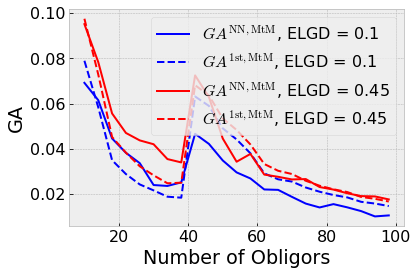

In [9]:
plt.plot(np.arange(10,101,4),[GA_01[i][0][0] for i in range(len(GA_01))],label = r"$GA^{\rm NN,MtM}$, ELGD = 0.1",color = "blue")
plt.plot(np.arange(10,101,4),GA_01_approx,label = r"$GA^{\rm 1st,MtM}$, ELGD = 0.1",linestyle = "dashed",color = "blue")
plt.plot(np.arange(10,101,4),[GA_045[i][0][0] for i in range(len(GA_045))],label = r"$GA^{\rm NN,MtM}$, ELGD = 0.45",color = "red")
plt.plot(np.arange(10,101,4),GA_045_approx,label = r"$GA^{\rm 1st,MtM}$, ELGD = 0.45",linestyle = "dashed",color = "red")
plt.xlabel("Number of Obligors")
plt.ylabel("GA")
plt.legend(loc="upper right")
plt.savefig('Plots/mtm_sensitivity_obligors_0999.pdf', format='pdf',bbox_inches='tight')
plt.show()

Consider reduced number of obligors

In [12]:
reduced_obligors = 50
N = np.zeros((1,max_obligors))
N[0,:] = np.pad(np.repeat(1,reduced_obligors),(0,max_obligors-reduced_obligors)) # Number of Obligors 
ELGD,EAD,rho,c,g,D = ELGD*N,EAD*N/np.sum(EAD*N),rho*N,c*N,g*N,D*N
LGD_Vector1 = np.zeros((1,100))
LGD_Vector2 = np.zeros((1,100))
LGD_Vector1[ELGD>0] = 0.1
LGD_Vector2[ELGD>0] = 0.45



### Visualization of the portfolio

In [13]:
# Convert g to PDs
g = np.maximum(g,4)
PD_Vector = np.array([PDs_reverted[int(g_val)-2] for g_val in g[0] if g_val != 0])
# Sort by EAD
tup = [(e,p) for (e,p) in zip(EAD[EAD>0],PD_Vector)]
tup.sort(key = lambda x: x[0]) 
EAD_Sorted = [e for (e,p) in tup]
PD_Sorted = [p for (e,p) in tup]
df =pd.DataFrame(tup)
df.columns = ["EAD","PD"]

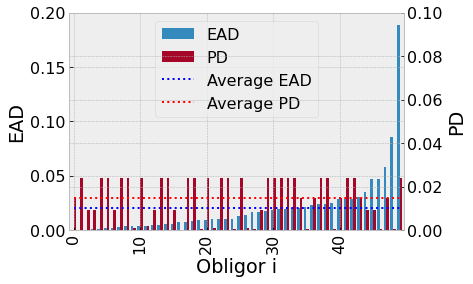

In [50]:
ax = df.plot(kind="bar",width = 0.8)
ax2 = ax.twinx()
for r in ax.patches[len(df):]:
    r.set_transform(ax2.transData)
ax.plot([np.mean(EAD_Sorted)]*50,color = "blue",linestyle = "dotted",label = "Average EAD")
ax2.plot([np.mean(PD_Sorted)]*50,color = "red",linestyle = "dotted",label = "Average PD")
ax2.set_ylim(0, 0.1)
ax.set_ylim(0, 0.2)
ax.set_xticks([0,10,20,30,40])
ax.set_ylabel('EAD')
ax2.set_ylabel('PD')
ax.set_xlabel('Obligor i')
# Combining legends
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
ax.legend([handles[i] for i in [1,2,0,3]],
          [labels[i] for i in [1,2,0,3]],loc = "upper center") # Rearrange Order
plt.savefig('Plots/mtm_sensitivity_Portfolio.pdf', format='pdf',bbox_inches='tight')
plt.show()

In [15]:
PD_01_change = []
PD_01_change_approx = []
# Compute base GA
GA_approx_01 = GA_GM(PD = 0, ELGD =LGD_Vector2[0,:][EAD[0,:]>0],
                                   A = EAD[0,:][EAD[0,:]>0], 
                         M= D[0,:][EAD[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g[0,:][EAD[0,:]>0],dtype = int),
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho[0,:][EAD[0,:]>0],
                     c = c[0,:][EAD[0,:]>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
Input_01 = np.concatenate([LGD_Vector2 ,EAD ,rho ,c,g,D,
                            np.reshape(GA_approx_01,(1,1))],axis =1)
base_GA = model_999.predict(scaler_mtm.transform(Input_01), verbose=0)
for i in range(50):
    print(i)
    # COmptue new GA
    g_new = np.copy(g)
    g_new[0,i]=g_new[0,i]-1
    g_new = tf.convert_to_tensor(g_new)
    GA_approx_02 = GA_GM(PD = 0, ELGD =LGD_Vector2[0,:][EAD[0,:]>0],
                                       A = EAD[0,:][EAD[0,:]>0], 
                             M= D[0,:][EAD[0,:]>0],
                          q=0.999,        
                         r = r_nelson,
                         T=1,
                         g= np.array(g_new[0,:][EAD[0,:]>0],dtype = int),
                         trans_prob=SP_dict["trans_prob"],#N times S matrix
                         psi = 0.4, # Market Sharpe Ratio,
                         rho = rho[0,:][EAD[0,:]>0],
                         c = c[0,:][EAD[0,:]>0],
                        nu =0.25,               
                         S = S, # Number of States of Rating
                         default_only = False,
                          LGD_constant = False)
    Input_02 = np.concatenate([LGD_Vector2 ,EAD ,rho ,c,g_new,D,
                                np.reshape(GA_approx_02,(1,1))],axis =1)
    # Compute difference
    PD_01_change.append((model_999.predict(scaler_mtm.transform(Input_02), verbose=0)-base_GA)[0][0])
    PD_01_change_approx.append(GA_approx_02-GA_approx_01)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [16]:
indices = np.argsort(EAD)
PD_01_change = [PD_01_change[i] for i  in indices[0][50:]]
PD_01_change_approx = [PD_01_change_approx[i] for i  in indices[0][50:]]

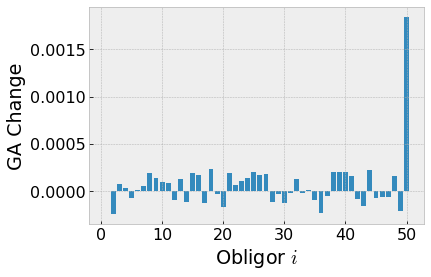

In [48]:
plt.bar(range(1,51),PD_01_change,label = r"$GA^{\rm NN,MtM}_{(i)} -GA^{\rm NN,MtM} $")
#plt.bar(range(1,51),np.array(PD_01_change_approx),color = "red",alpha = 0.2)
plt.ylabel("GA Change", rotation= 90)
plt.xlabel("Obligor $i$")
#plt.legend()
plt.savefig('Plots/mtm_sensitivity_PD_Change.pdf', format='pdf',bbox_inches='tight')
plt.show()

In [18]:
EAD_01_change = []
EAD_01_change_approx = []
# Compute base GA
GA_approx_01 = GA_GM(PD = 0, ELGD =LGD_Vector2[0,:][EAD[0,:]>0],
                                   A = EAD[0,:][EAD[0,:]>0], 
                         M= D[0,:][EAD[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g[0,:][EAD[0,:]>0],dtype = int),
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho[0,:][EAD[0,:]>0],
                     c = c[0,:][EAD[0,:]>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
Input_01 = np.concatenate([LGD_Vector2 ,EAD ,rho ,c,g,D,
                            np.reshape(GA_approx_01,(1,1))],axis =1)
base_GA = model_999.predict(scaler_mtm.transform(Input_01), verbose=0)
for i in range(50):
    print(i)
    # Increase EAD of obligor i
    EAD_Vector_mod = np.copy(EAD)
    EAD_Vector_mod[0][i]+= 0.01
    EAD_Vector_mod = tf.convert_to_tensor(EAD_Vector_mod)
    EAD_Vector_mod = EAD_Vector_mod/tf.reduce_sum(EAD_Vector_mod)
    # COmptue new GA
    GA_approx_02 = GA_GM(PD = 0, ELGD =LGD_Vector2[0,:][EAD[0,:]>0],
                                       A = EAD_Vector_mod[0,:][EAD[0,:]>0], 
                             M= D[0,:][EAD[0,:]>0],
                          q=0.999,        
                         r = r_nelson,
                         T=1,
                         g= np.array(g[0,:][EAD[0,:]>0],dtype = int),
                         trans_prob=SP_dict["trans_prob"],#N times S matrix
                         psi = 0.4, # Market Sharpe Ratio,
                         rho = rho[0,:][EAD[0,:]>0],
                         c = c[0,:][EAD[0,:]>0],
                        nu =0.25,               
                         S = S, # Number of States of Rating
                         default_only = False,
                          LGD_constant = False)
    Input_02 = np.concatenate([LGD_Vector2 ,EAD_Vector_mod ,rho ,c,g,D,
                                np.reshape(GA_approx_02,(1,1))],axis =1)
    # Compute difference
    EAD_01_change.append((model_999.predict(scaler_mtm.transform(Input_02), verbose=0)-base_GA)[0][0])
    EAD_01_change_approx.append(GA_approx_02-GA_approx_01)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [19]:
indices = np.argsort(EAD)
EAD_01_change = [EAD_01_change[i] for i  in indices[0][50:]]
EAD_01_change_approx = [EAD_01_change_approx[i] for i  in indices[0][50:]]

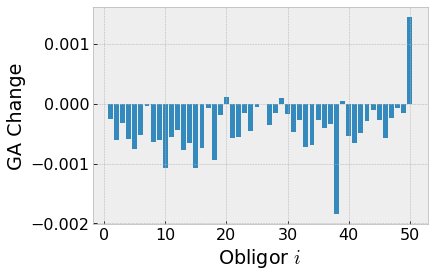

In [49]:
plt.bar(range(1,51),EAD_01_change,label = r"$GA^{\rm NN,MtM}_{(i)} -GA^{\rm NN,MtM} $")
#plt.bar(range(1,51),np.array(EAD_01_change_approx),color = "red",alpha = 0.2)
plt.ylabel("GA Change", rotation= 90)
plt.xlabel("Obligor $i$")
#plt.legend()
plt.savefig('Plots/mtm_sensitivity_EAD_Change.pdf', format='pdf',bbox_inches='tight')
plt.show()

Changing g

In [21]:
GA_01 = []
GA_01_approx  = []
GA_045 = []
GA_045_approx  = []

step_size = 0.1
for g_factor in np.arange(0.5,2,step_size): 
    LGD_Vector_new_01 = LGD_Vector1*N
    LGD_Vector_new_045 = LGD_Vector2*N
    EAD_Vector_new  = EAD*N
    rho_Vector_new  = rho*N
    c_Vector_new  = c*N
    g_Vector_new  = g*N
    g_Vector_new = np.array(np.minimum(g_Vector_new*g_factor,12),dtype = int)
    D_Vector_new  = D*N
    EAD_Vector_new   = EAD_Vector_new /np.repeat(np.sum(EAD_Vector_new ,1)[:,np.newaxis],max_obligors,axis = 1)
    
    GA_approx_01 = GA_GM(PD = 0, ELGD =LGD_Vector_new_01[0,:][EAD_Vector_new[0,:]>0],
                                   A = EAD_Vector_new[0,:][EAD_Vector_new[0,:]>0], 
                         M= D_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g_Vector_new[0,:][EAD_Vector_new[0,:]>0],dtype = int),
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                     c = c_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
    
    GA_approx_045 = GA_GM(PD = 0, ELGD =LGD_Vector_new_045[0,:][EAD_Vector_new[0,:]>0],
                                   A = EAD_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                          M= D_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g_Vector_new[0,:][EAD_Vector_new[0,:]>0],dtype = int),
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                     c = c_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
    Input_01 = np.concatenate([LGD_Vector_new_01 ,EAD_Vector_new ,rho_Vector_new ,c_Vector_new,g_Vector_new,D_Vector_new,
                            np.reshape(GA_approx_01,(1,1))],axis =1)
    Input_045 = np.concatenate([LGD_Vector_new_045 ,EAD_Vector_new ,rho_Vector_new ,c_Vector_new,g_Vector_new,D_Vector_new,
                            np.reshape(GA_approx_045,(1,1))],axis =1)
    GA_mtm_new_01  = model_999.predict(scaler_mtm.transform(Input_01), verbose=0)
    GA_01.append(GA_mtm_new_01)
    GA_01_approx.append(GA_approx_01)
    GA_mtm_new_045  = model_999.predict(scaler_mtm.transform(Input_045), verbose=0)
    GA_045.append(GA_mtm_new_045)
    GA_045_approx.append(GA_approx_045)

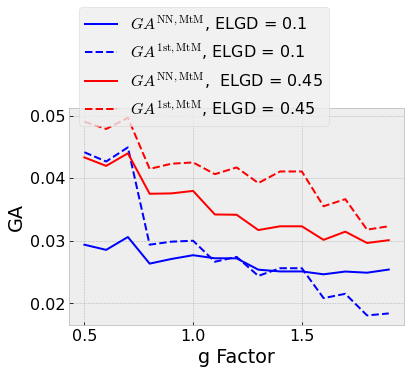

In [22]:
plt.plot(np.arange(0.5,2,0.1),[GA_01[i][0][0] for i in range(len(GA_01))],label = r"$GA^{\rm NN,MtM}$, ELGD = 0.1",color = "blue")
plt.plot(np.arange(0.5,2,0.1),GA_01_approx,label = r"$GA^{\rm 1st,MtM}$, ELGD = 0.1",linestyle = "dashed",color = "blue")
plt.plot(np.arange(0.5,2,0.1),[GA_045[i][0][0] for i in range(len(GA_045))],label = r"$GA^{\rm NN,MtM}$,  ELGD = 0.45",color = "red")
plt.plot(np.arange(0.5,2,0.1),GA_045_approx,label = r"$GA^{\rm 1st,MtM}$, ELGD = 0.45",linestyle = "dashed",color = "red")
plt.xlabel("g Factor")
plt.ylabel("GA")
plt.legend(loc="upper right", bbox_to_anchor=(0.8, 1.5))
plt.savefig('Plots/mtm_sensitivity_obligors_g_0999.pdf', format='pdf',bbox_inches='tight')
plt.show()

Changing D

In [23]:
GA_01 = []
GA_01_approx  = []
GA_045 = []
GA_045_approx  = []

step_size = 0.1
for D_factor in np.arange(0.5,2,step_size): 
    LGD_Vector_new_01 = LGD_Vector1*N
    LGD_Vector_new_045 = LGD_Vector2*N
    EAD_Vector_new  = EAD*N
    rho_Vector_new  = rho*N
    c_Vector_new  = c*N
    g_Vector_new  = g*N
    D_Vector_new  = D*N
    D_Vector_new = D_Vector_new*D_factor
    EAD_Vector_new   = EAD_Vector_new /np.repeat(np.sum(EAD_Vector_new ,1)[:,np.newaxis],max_obligors,axis = 1)
    
    GA_approx_01 = GA_GM(PD = 0, ELGD =LGD_Vector_new_01[0,:][EAD_Vector_new[0,:]>0],
                                   A = EAD_Vector_new[0,:][EAD_Vector_new[0,:]>0], 
                         M= D_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g_Vector_new[0,:][EAD_Vector_new[0,:]>0],dtype = int),
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                     c = c_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
    
    GA_approx_045 = GA_GM(PD = 0, ELGD =LGD_Vector_new_045[0,:][EAD_Vector_new[0,:]>0],
                                   A = EAD_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                          M= D_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g_Vector_new[0,:][EAD_Vector_new[0,:]>0],dtype = int),
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                     c = c_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
    Input_01 = np.concatenate([LGD_Vector_new_01 ,EAD_Vector_new ,rho_Vector_new ,c_Vector_new,g_Vector_new,D_Vector_new,
                            np.reshape(GA_approx_01,(1,1))],axis =1)
    Input_045 = np.concatenate([LGD_Vector_new_045 ,EAD_Vector_new ,rho_Vector_new ,c_Vector_new,g_Vector_new,D_Vector_new,
                            np.reshape(GA_approx_045,(1,1))],axis =1)
    GA_mtm_new_01  = model_999.predict(scaler_mtm.transform(Input_01), verbose=0)
    GA_01.append(GA_mtm_new_01)
    GA_01_approx.append(GA_approx_01)
    GA_mtm_new_045  = model_999.predict(scaler_mtm.transform(Input_045), verbose=0)
    GA_045.append(GA_mtm_new_045)
    GA_045_approx.append(GA_approx_045)

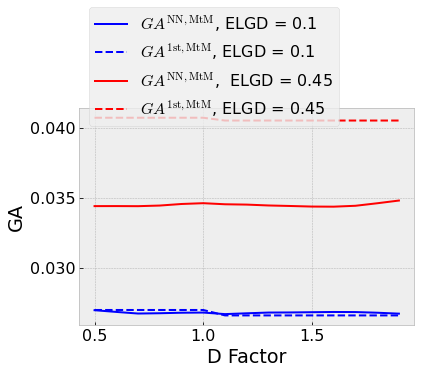

In [24]:
plt.plot(np.arange(0.5,2,step_size),[GA_01[i][0][0] for i in range(len(GA_01))],label = r"$GA^{\rm NN,MtM}$, ELGD = 0.1",color = "blue")
plt.plot(np.arange(0.5,2,step_size),GA_01_approx,label = r"$GA^{\rm 1st,MtM}$, ELGD = 0.1",linestyle = "dashed",color = "blue")
plt.plot(np.arange(0.5,2,step_size),[GA_045[i][0][0] for i in range(len(GA_045))],label = r"$GA^{\rm NN,MtM}$,  ELGD = 0.45",color = "red")
plt.plot(np.arange(0.5,2,step_size),GA_045_approx,label = r"$GA^{\rm 1st,MtM}$, ELGD = 0.45",linestyle = "dashed",color = "red")
plt.xlabel("D Factor")
plt.ylabel("GA")
plt.legend(loc="upper right", bbox_to_anchor=(0.8, 1.5))
plt.savefig('Plots/mtm_sensitivity_obligors_D_0999.pdf', format='pdf',bbox_inches='tight')
plt.show()

Changing rho

In [25]:
GA_01 = []
GA_01_approx  = []
GA_045 = []
GA_045_approx  = []

step_size = 0.1
for rho_factor in np.arange(0.5,2,step_size): 
    LGD_Vector_new_01 = LGD_Vector1*N
    LGD_Vector_new_045 = LGD_Vector2*N
    EAD_Vector_new  = EAD*N
    rho_Vector_new  = rho*N
    rho_Vector_new= rho_Vector_new*rho_factor
    c_Vector_new  = c*N
    g_Vector_new  = g*N
    D_Vector_new  = D*N
    EAD_Vector_new   = EAD_Vector_new /np.repeat(np.sum(EAD_Vector_new ,1)[:,np.newaxis],max_obligors,axis = 1)
    
    GA_approx_01 = GA_GM(PD = 0, ELGD =LGD_Vector_new_01[0,:][EAD_Vector_new[0,:]>0],
                                   A = EAD_Vector_new[0,:][EAD_Vector_new[0,:]>0], 
                         M= D_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g_Vector_new[0,:][EAD_Vector_new[0,:]>0],dtype = int),
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                     c = c_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
    
    GA_approx_045 = GA_GM(PD = 0, ELGD =LGD_Vector_new_045[0,:][EAD_Vector_new[0,:]>0],
                                   A = EAD_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                          M= D_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g_Vector_new[0,:][EAD_Vector_new[0,:]>0],dtype = int),
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                     c = c_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
    Input_01 = np.concatenate([LGD_Vector_new_01 ,EAD_Vector_new ,rho_Vector_new ,c_Vector_new,g_Vector_new,D_Vector_new,
                            np.reshape(GA_approx_01,(1,1))],axis =1)
    Input_045 = np.concatenate([LGD_Vector_new_045 ,EAD_Vector_new ,rho_Vector_new ,c_Vector_new,g_Vector_new,D_Vector_new,
                            np.reshape(GA_approx_045,(1,1))],axis =1)
    GA_mtm_new_01  = model_999.predict(scaler_mtm.transform(Input_01), verbose=0)
    GA_01.append(GA_mtm_new_01)
    GA_01_approx.append(GA_approx_01)
    GA_mtm_new_045  = model_999.predict(scaler_mtm.transform(Input_045), verbose=0)
    GA_045.append(GA_mtm_new_045)
    GA_045_approx.append(GA_approx_045)

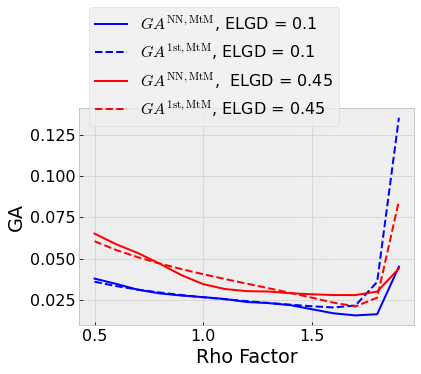

In [26]:
plt.plot(np.arange(0.5,2,step_size),[GA_01[i][0][0] for i in range(len(GA_01))],label = r"$GA^{\rm NN,MtM}$, ELGD = 0.1",color = "blue")
plt.plot(np.arange(0.5,2,step_size),GA_01_approx,label = r"$GA^{\rm 1st,MtM}$, ELGD = 0.1",linestyle = "dashed",color = "blue")
plt.plot(np.arange(0.5,2,step_size),[GA_045[i][0][0] for i in range(len(GA_045))],label = r"$GA^{\rm NN,MtM}$,  ELGD = 0.45",color = "red")
plt.plot(np.arange(0.5,2,step_size),GA_045_approx,label = r"$GA^{\rm 1st,MtM}$, ELGD = 0.45",linestyle = "dashed",color = "red")

plt.xlabel("Rho Factor")
plt.ylabel("GA")
plt.legend(loc="upper right", bbox_to_anchor=(0.8, 1.5))
plt.savefig('Plots/mtm_sensitivity_obligors_rho_0999.pdf', format='pdf',bbox_inches='tight')
plt.show()

Changing c

In [27]:
GA_01 = []
GA_01_approx  = []
GA_045 = []
GA_045_approx  = []

step_size = 0.1
for c_factor in np.arange(0.5,2,step_size): 
    LGD_Vector_new_01 = LGD_Vector1*N
    LGD_Vector_new_045 = LGD_Vector2*N
    EAD_Vector_new  = EAD*N
    rho_Vector_new  = rho*N
    c_Vector_new  = c*N
    c_Vector_new  = c_factor*c_Vector_new
    g_Vector_new  = g*N
    D_Vector_new  = D*N
    EAD_Vector_new   = EAD_Vector_new /np.repeat(np.sum(EAD_Vector_new ,1)[:,np.newaxis],max_obligors,axis = 1)
    
    GA_approx_01 = GA_GM(PD = 0, ELGD =LGD_Vector_new_01[0,:][EAD_Vector_new[0,:]>0],
                                   A = EAD_Vector_new[0,:][EAD_Vector_new[0,:]>0], 
                         M= D_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g_Vector_new[0,:][EAD_Vector_new[0,:]>0],dtype = int),
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                     c = c_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
    
    GA_approx_045 = GA_GM(PD = 0, ELGD =LGD_Vector_new_045[0,:][EAD_Vector_new[0,:]>0],
                                   A = EAD_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                          M= D_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g_Vector_new[0,:][EAD_Vector_new[0,:]>0],dtype = int),
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                     c = c_Vector_new[0,:][EAD_Vector_new[0,:]>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
    Input_01 = np.concatenate([LGD_Vector_new_01 ,EAD_Vector_new ,rho_Vector_new ,c_Vector_new,g_Vector_new,D_Vector_new,
                            np.reshape(GA_approx_01,(1,1))],axis =1)
    Input_045 = np.concatenate([LGD_Vector_new_045 ,EAD_Vector_new ,rho_Vector_new ,c_Vector_new,g_Vector_new,D_Vector_new,
                            np.reshape(GA_approx_045,(1,1))],axis =1)
    GA_mtm_new_01  = model_999.predict(scaler_mtm.transform(Input_01), verbose=0)
    GA_01.append(GA_mtm_new_01)
    GA_01_approx.append(GA_approx_01)
    GA_mtm_new_045  = model_999.predict(scaler_mtm.transform(Input_045), verbose=0)
    GA_045.append(GA_mtm_new_045)
    GA_045_approx.append(GA_approx_045)

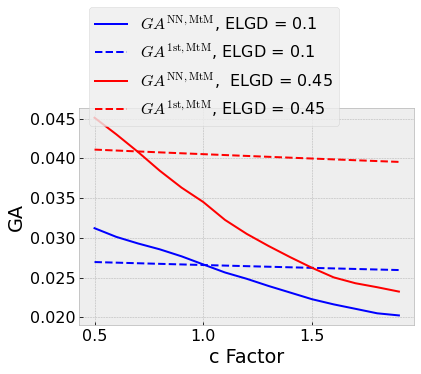

In [28]:
plt.plot(np.arange(0.5,2,step_size),[GA_01[i][0][0] for i in range(len(GA_01))],label = r"$GA^{\rm NN,MtM}$, ELGD = 0.1",color = "blue")
plt.plot(np.arange(0.5,2,step_size),GA_01_approx,label = r"$GA^{\rm 1st,MtM}$, ELGD = 0.1",linestyle = "dashed",color = "blue")
plt.plot(np.arange(0.5,2,step_size),[GA_045[i][0][0] for i in range(len(GA_045))],label = r"$GA^{\rm NN,MtM}$,  ELGD = 0.45",color = "red")
plt.plot(np.arange(0.5,2,step_size),GA_045_approx,label = r"$GA^{\rm 1st,MtM}$, ELGD = 0.45",linestyle = "dashed",color = "red")
plt.xlabel("c Factor")
plt.ylabel("GA")
plt.legend(loc="upper right", bbox_to_anchor=(0.8, 1.5))
plt.savefig('Plots/mtm_sensitivity_obligors_c_0999.pdf', format='pdf',bbox_inches='tight')
plt.show()